In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Preanalysis

The data set consists of headshots of 28 celebrities. There are several potential problems:

1) one's hairstyle or hair color is sometimes different in different pictures. Sometimes a person wearing sunglasses, which covers part of her or his face.


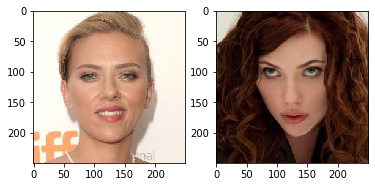

In [16]:
path = 'C:/Users/Piotr Grabysz/Documents/GSN data/dnn2020-1/train/'
img1 = mpimg.imread(path + '0424060/106.jpg')
img2 = mpimg.imread(path + '0424060/129.jpg')

plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)

2) some of the pictures are taken from movies, where a person might have strong makeup, 
or just look unusual. At picture below, without knowing the context (it's, seeing Star Wars)
it is impossible to know which actress is this. There are pictures, which also seem to be taken from some movie,
where there are harsh shadows on actor's face, making it difficult to recognize as well.

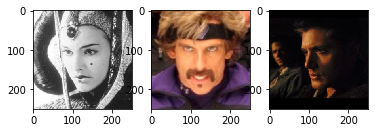

In [19]:
img1 = mpimg.imread(path + '0000204/270.jpg')
img2 = mpimg.imread(path + '0001774/172.jpg')
img3 = mpimg.imread(path + '0010075/133.jpg')

plt.subplot(1,3,1)
plt.imshow(img1)
plt.subplot(1,3,2)
plt.imshow(img2)
plt.subplot(1,3,3)
plt.imshow(img3)

3) different pictures are taken from different angles, so the network has to learn different parts
of a face of one person.

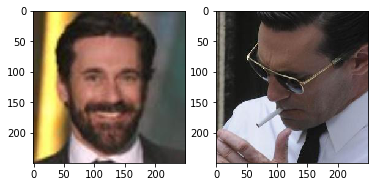

In [18]:
img1 = mpimg.imread(path + '0358316/154.jpg')
img2 = mpimg.imread(path + '0358316/495.jpg')

plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)

4) some pictures have very poor resolution, containing much less information about the subject.

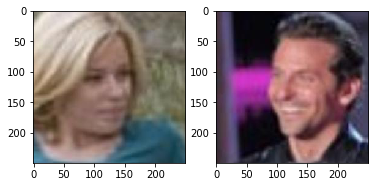

In [20]:
img1 = mpimg.imread(path + '0006969/163.jpg')
img2 = mpimg.imread(path + '0177896/262.jpg')

plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)

5) it happens that there is a second person on the picture, or even that the picture is incorrectly labaled. The pictures below are in Natalie Portman category.

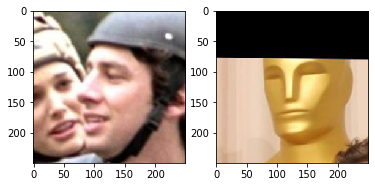

In [21]:
img1 = mpimg.imread(path + '0000204/174.jpg')
img2 = mpimg.imread(path + '0000204/286.jpg')

plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)

Having said that, there is a lot of very similar pictures in every category. Assuming that there is
around of 10% of difficult pictures in every category, I would suggest that the clasiffier should reach
90% accuracy, although as it can be seen later, it turns out that it is too optimistic guess. I would also
expect that accuracy depends on particular class. For example class 0000204, that is Natalie Portman, contains
many pictures which vary a lot (to my eye), so I would expect this class to have lower accuracy than others.
This might be verified via confusion matrix.

## Implementation

In both networks, one with and without batch normalization I used 4 convolutional layers and 2 fully connected layers. It is often said that initial convolutional layers learn basic representation,  like horizontal or vertical lines, while later layers learn more abstract concepts. This is a reason why I use small 3x3 filter in first layer, than I used 5x5 filters and 7x7 at the last layer. I use stride 1x1 and no padding in every layer. There is no reason why I used this particular number of filters. I just thought that this database is too small to use more.

In the case of network with batch normalization, I set biases of every layer but last to False (I didn't use batch normalization only after the last layer).

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [2]:
train_path = 'C:/Users/Piotr Grabysz/Documents/GSN data/dnn2020-1/train/'
train_dataset = torchvision.datasets.ImageFolder(
        root=train_path,
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
)
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=16,
        num_workers=0,
        shuffle=True
    )

test_path = 'C:/Users/Piotr Grabysz/Documents/GSN data/dnn2020-1/test/'
test_dataset = torchvision.datasets.ImageFolder(
        root=test_path,
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=99,
        num_workers=0,
        shuffle=False
    )

Below I define network without batch normalization:

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 7)
        
        self.fc1 = nn.Linear(32 * 11 * 11, 1000)
        self.fc2 = nn.Linear(1000, 28)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
                
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = x.view(-1, 32*11*11)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

In the next cells I define batch normalization layers (1d and 2d) and I construct the networks with these layers. I initialize all gammas (the term with we multiply) as 1 and all betas (the term which we add) as 0. In fact, this a kind of initialiaztion I found in implementation of BatchNorm in pytorch. 

In [4]:
import sys

class BatchNorm1D(nn.Module):
    def __init__(self, n_nodes):
        super().__init__()
        self.n_nodes = n_nodes
        self.beta = torch.nn.Parameter(torch.zeros(n_nodes))
        self.gamma = torch.nn.Parameter(torch.ones(n_nodes))
        self.epsilon = 10e-5
    def forward(self, input):
        _, n = input.shape
        if n != self.n_nodes:
            sys.exit('Wrong number of nodes!')
        
        input_mean = torch.mean(input, dim = 0)
        input_var = torch.var(input, dim = 0)
        output = torch.sub(input, input_mean)
        output.div_(torch.sqrt(input_var + self.epsilon))
        output.mul_(self.gamma)
        output.add_(self.beta)
        return output

class BatchNorm2D(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.n_channels = n_channels
        self.beta = torch.nn.Parameter(torch.zeros(n_channels))
        self.gamma = torch.nn.Parameter(torch.ones(n_channels))
        self.epsilon = 10e-5
    def forward(self, input):
        n = input.shape[1]
        if n != self.n_channels:
            sys.exit('Wrong number of nodes!')
        
        input_mean = torch.mean(input, dim = (0,2,3))
        input_var = torch.var(input, dim = (0,2,3))
        output = torch.sub(input, input_mean[None,:, None, None])
        output.div_(torch.sqrt(input_var[None,:, None, None] + self.epsilon))
        output.mul_(self.gamma[None,:, None, None])
        output.add_(self.beta[None, :, None, None])
        return output

In [7]:
class Net_with_BatchNorm(nn.Module):
    def __init__(self):
        super(Net_with_BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, bias = False)
        self.bn1 = BatchNorm2D(16)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, bias = False)
        self.bn2 = BatchNorm2D(16)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, bias = False)
        self.bn3 = BatchNorm2D(32)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 7, bias = False)
        self.bn4 = BatchNorm2D(32)
        
        self.fc1 = nn.Linear(32 * 11 * 11, 1000, bias = False)
        self.bn5 = BatchNorm1D(1000)
        self.fc2 = nn.Linear(1000, 28)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
                
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = x.view(-1, 32*11*11)
        x = self.fc1(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x


net_bn = Net_with_BatchNorm()
print(net_bn)

Net_with_BatchNorm(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2D()
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn2): BatchNorm2D()
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn3): BatchNorm2D()
  (conv4): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (bn4): BatchNorm2D()
  (fc1): Linear(in_features=3872, out_features=1000, bias=False)
  (bn5): BatchNorm1D()
  (fc2): Linear(in_features=1000, out_features=28, bias=True)
)


## Experiments

I trained the networks with SGD with momentum, setting learning rate to 0.01
for the first 5 epochs, than dropping it to 0.001. I also tried with adam 
optimizer, but it surprisingly saturated around 4% of accuracy (or maybe I did something wrong).

For an unknown reason, the network with batch normalization learnt very bad. I also tried RMSprop optimizer, and bigger batch size (64), but it didn't help.

In [10]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net.parameters(), lr = 0.01)
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)

In [32]:
losses = []
for epoch in range(5): 
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    ###Compute accuracy on test set after finishing each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images in {:} epoch: {:.2f}%'.format(epoch +1, 100 * correct / total))
    
print('Finished Training')

Accuracy of the network on the test images in 1 epoch: 32.61%
Accuracy of the network on the test images in 2 epoch: 49.68%
Accuracy of the network on the test images in 3 epoch: 59.42%
Accuracy of the network on the test images in 4 epoch: 64.36%
Accuracy of the network on the test images in 5 epoch: 59.67%
Finished Training


In [34]:
PATH = './net_after_5_epoch_lr_10e-2.pth'
torch.save(net.state_dict(), PATH)

In [36]:
net.load_state_dict(torch.load(PATH))
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

for epoch in range(5): 
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    ###Compute accuracy on test set after finishing each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images in {:} epoch: {:.2f}%'.format(epoch +6, 100 * correct / total))

PATH = './net_after_10_epoch_lr_10e-3.pth'
torch.save(net.state_dict(), PATH)

for epoch in range(5): 
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    ###Compute accuracy on test set after finishing each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images in {:} epoch: {:.2f}%'.format(epoch +11, 100 * correct / total))
PATH = './net_after_1_epoch_lr_10e-3.pth'
torch.save(net.state_dict(), PATH)

Accuracy of the network on the test images in 6 epoch: 70.38%
Accuracy of the network on the test images in 7 epoch: 70.38%
Accuracy of the network on the test images in 8 epoch: 70.38%
Accuracy of the network on the test images in 9 epoch: 70.20%
Accuracy of the network on the test images in 10 epoch: 70.35%
Accuracy of the network on the test images in 11 epoch: 70.31%
Accuracy of the network on the test images in 12 epoch: 70.31%
Accuracy of the network on the test images in 13 epoch: 70.17%
Accuracy of the network on the test images in 14 epoch: 70.20%
Accuracy of the network on the test images in 15 epoch: 70.17%


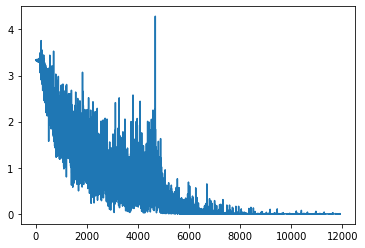

In [37]:
plt.plot(losses)

It can be seen that the loss is almost 0. The accuracy on the training set is:

In [48]:
PATH = './net_after_15_epoch_lr_10e-3.pth'
net.load_state_dict(torch.load(PATH))

correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the training set : {:.2f}%'.format(100 * correct / total))

Accuracy of the network on the training set : 100.00%


### Training the network with batch normalization:
For the sake of time, I interrupt this session, seeing that optimizer is behaving very poorly

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_bn.parameters(), lr = 0.01, momentum = 0.9)

losses = []
for epoch in range(5): 
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_bn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    ###Compute accuracy on test set after finishing each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net_bn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images in {:} epoch: {:.2f}%'.format(epoch +1 , 100 * correct / total))
    
print('Finished Training')

Accuracy of the network on the test images in 1 epoch: 6.24%


KeyboardInterrupt: 

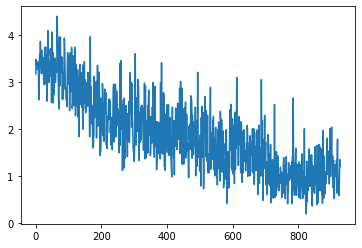

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [14]:
net_bn = Net_with_BatchNorm()
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True
    )

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_bn.parameters())

losses = []
for epoch in range(5): 
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_bn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    ###Compute accuracy on test set after finishing each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net_bn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images in {:} epoch: {:.2f}%'.format(epoch +1 , 100 * correct / total))
    
print('Finished Training')

Accuracy of the network on the test images in 1 epoch: 4.80%


KeyboardInterrupt: 

## Confusion matrix

Firstly, I reload the Networks with the highest accuracy

In [35]:
net = Net()

PATH = './net_after_15_epoch_lr_10e-3.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [40]:
confusion_matrix = torch.zeros(28,28)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(28):
            tmp_idx = torch.where(predicted == i)
            for j in labels[tmp_idx]:
                confusion_matrix[i, j] = confusion_matrix[i, j] +  1

In [42]:
#Sanity check if confusion_matrix contains the same number of elements as test set
#There are 28 classes, each of them has 99 representatives in the test set
print(torch.sum(confusion_matrix) == 99*28) 

tensor(True)


In [45]:
print("Accuracy per class:")
for i in range(28):
    print("Accuracy of class {:} : {:.2f}%".format(i, 100 * confusion_matrix[i,i] / 99))

Accuracy per class:
Accuracy of class 0 : 67.68%
Accuracy of class 1 : 57.58%
Accuracy of class 2 : 68.69%
Accuracy of class 3 : 72.73%
Accuracy of class 4 : 78.79%
Accuracy of class 5 : 69.70%
Accuracy of class 6 : 77.78%
Accuracy of class 7 : 78.79%
Accuracy of class 8 : 68.69%
Accuracy of class 9 : 67.68%
Accuracy of class 10 : 66.67%
Accuracy of class 11 : 68.69%
Accuracy of class 12 : 66.67%
Accuracy of class 13 : 73.74%
Accuracy of class 14 : 59.60%
Accuracy of class 15 : 78.79%
Accuracy of class 16 : 77.78%
Accuracy of class 17 : 56.57%
Accuracy of class 18 : 69.70%
Accuracy of class 19 : 66.67%
Accuracy of class 20 : 74.75%
Accuracy of class 21 : 70.71%
Accuracy of class 22 : 71.72%
Accuracy of class 23 : 68.69%
Accuracy of class 24 : 61.62%
Accuracy of class 25 : 81.82%
Accuracy of class 26 : 61.62%
Accuracy of class 27 : 80.81%


Below I print the whole confusion matrix. Element (i, j) means: predicted as a class i, in fact belonging to a class j. 

In [46]:
print(confusion_matrix)

tensor([[67.,  3.,  0.,  0.,  1.,  3.,  0.,  0.,  1.,  0.,  3.,  2.,  0.,  1.,
          3.,  0.,  0.,  5.,  1.,  0.,  0.,  4.,  0.,  3.,  3.,  0.,  2.,  2.],
        [ 1., 57.,  1.,  2.,  0.,  0.,  0.,  0.,  3.,  1.,  0.,  4.,  3.,  1.,
          5.,  0.,  0.,  2.,  0.,  2.,  2.,  0.,  1.,  5.,  2.,  0.,  0.,  0.],
        [ 0.,  1., 68.,  9.,  1.,  0.,  1.,  3.,  0.,  0.,  1.,  0.,  0.,  1.,
          2.,  1.,  3.,  2.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  2.,  1.],
        [ 3.,  0.,  5., 72.,  1.,  0.,  2.,  3.,  0.,  3.,  3.,  3.,  4.,  6.,
          3.,  0.,  1.,  0.,  2.,  0.,  3.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  3.,  4.,  1., 78.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  7.,
          1.,  1.,  3.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.],
        [ 1.,  1.,  0.,  0.,  0., 69.,  0.,  0.,  5.,  0.,  2.,  0.,  0.,  0.,
          4.,  2.,  0.,  1.,  0.,  4.,  1.,  0.,  0.,  2.,  2.,  2.,  1.,  0.],
        [ 0.,  0.,  1.,  4.,  3.,  1., 77.,  0